# Week 9

## Unsupervised Learning

## This Notebook Covers:
---
- Data preprocessing
  - K-Means
  - Hierarchical Clustering
  - Scaling and normalization
  - Dimensionality reduction
  

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from pandas import DataFrame

plt.style.use("ggplot")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# function for generating normally distributed data|
def sample_cluster(n, x, y, sigma):
    x = np.random.randn(n) * sigma + x;
    y = np.random.randn(n) * sigma + y;
    return np.array([x, y]).T


## Unsupervised vs Supervised
---
In supervised learning, we have *labeled* data:
- some input variables 
- some additional variable(s) which we are learning to predict

For example, we might have a classification problem like the one below (colors = class labels):

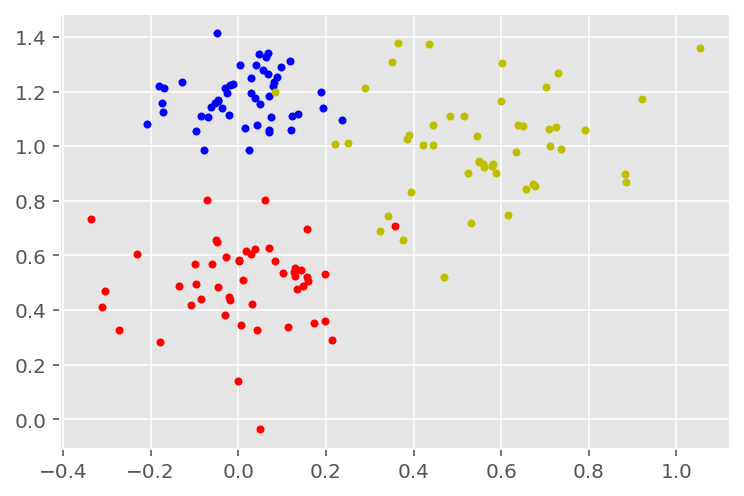

In [3]:
np.random.seed(1234)
c1 = sample_cluster(50, 0, 0.5, 0.15)
c2 = sample_cluster(50, 0, 1.2, 0.1)
c3 = sample_cluster(50, 0.5, 1, 0.2)
plt.plot(c1[:,0], c1[:,1], 'r.', c2[:,0], c2[:,1], 'b.', c3[:,0], c3[:,1], 'y.',)
plt.show()

*Unsupervised* algorithms don't require or consider target variables, unlike classification and regression algorithms.

In *unsupervised* learning, we are given no labels, and we seek to find hidden patterns in the data: 

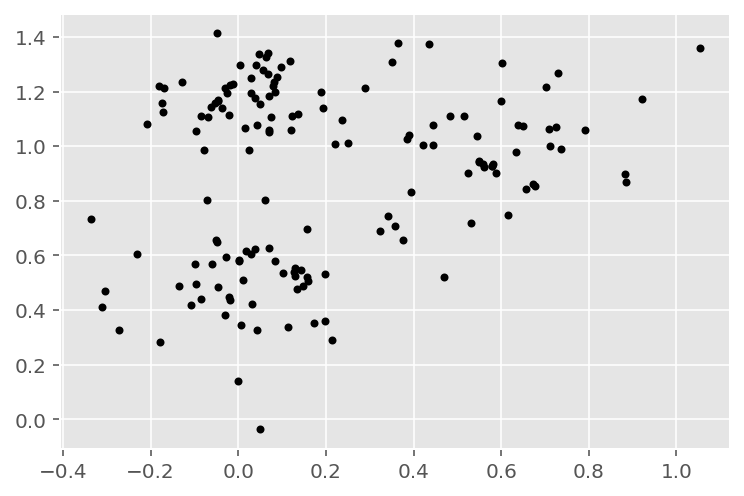

In [4]:
plt.plot(c1[:,0], c1[:,1], 'k.', c2[:,0], c2[:,1], 'k.', c3[:,0], c3[:,1], 'k.',)
plt.show()

Questions we could ask about the data:

- Is there a transformation of the data which will reveal patterns (to humans or algorithms)?
- What are the relevant features of the data which are informative?
- Are there natural groupings into which we could separate the data?

## Challenges of Unsupervised Learning
---
Since we have no labeled data, there are no predictions that we can make *and meaningfully test*.

Evaluation of unsupervised learning algorithms is often largely subjective.

Unsupervised learning is often used in *exploratory data analysis*.

In [5]:
# function for generating normally distributed data|
def sample_cluster(n, x, y, sigma):
    x = np.random.randn(n) * sigma + x;
    y = np.random.randn(n) * sigma + y;
    return np.array([x, y]).T


## Synthetic Clustering Example
---

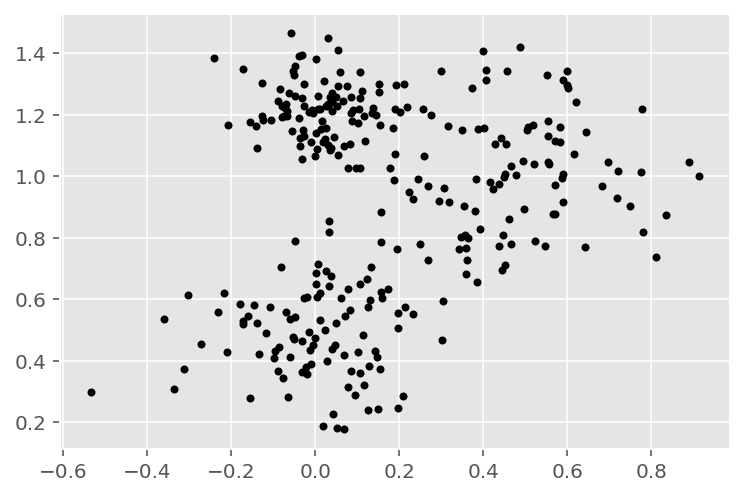

In [6]:
np.random.seed(1234)
c1 = sample_cluster(100, 0, 0.5, 0.15)
c2 = sample_cluster(100, 0, 1.2, 0.1)
c3 = sample_cluster(100, 0.5, 1, 0.2)
data = np.concatenate((c1, c2, c3))
plt.plot(data[:,0], data[:,1], 'k.')
plt.show()

## Clustering
---
Simple idea:

- Choose $K$ (decide how many clusters you *think* there ought to be)
- Partition the data into $K$ disjoint clusters such that $\sum_{k=1}^K W(C_k)$ is minimized.
  - W(C) is some measure of within-cluster variation
  - Common choice for W is the sum of Euclidean distances between pairs of points:
  
  $$ W(C_k) = \frac{1}{|C_k|} \sum_{pairs(x,y): x, y \in C_k, x \ne y} \|x - y\|^2 $$

Clustering Assumptions:
- Data is representative of the population
- Multiocollinearity
- K-Means clustering
    - Assumes clusters are spherical
    - Assumes clusters are equal in size
    - Assumes variables are continuous.

## Solution Approaches
---
- Brute force: try every possible partitions of the data
  - Advantage: globally optimal
  - Disadvantage: $\approx K^n$ different partitions (given $n$ data points)
- K-Means algorithm: iterative improvement
  - Advantage: efficient
  - Disadvantage: locally optimal, result depends on initialization
  - K-means is very sensitive to outlier points. Therefore, before applying k-means clustering, make sure to investigate the outliers. This goes back to one of the first steps in applying any ML algorithm which was data visualization. <br> If the outliers are invalid, make sure to remove them prior to using k-means algorithm. Otherwise, use an algorithm such as DBSCAN which is more robust to noise.
  - K-means requires the number of clusters to be defined. This could also be classified as a disadvantage.


## K-Means Algorithm
---
- Various initialization schemes
  - One way is to assign each point a cluster identity at random
  - Another is to choose K points to serve as initial cluster centers at random
- Iterate until cluster assignments stop changing:
  - Compute the cluster *centroids*.  The centroid is the mean point (vector of means of all features) for all points in the cluster
  - Re-assign each data point to the cluster associated with the nearest centroid

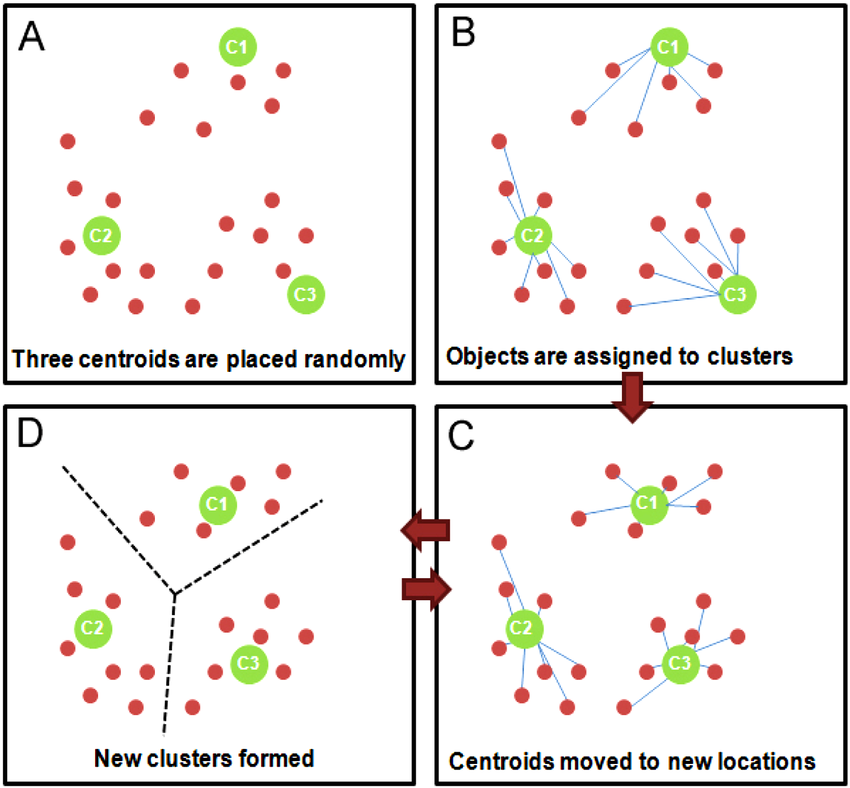

This algorithm is ridiculously easy to code up.

In [7]:
# a simple k-means implementation
# input: integer K, ndarray data
def KMeans(K, data):
    n = data.shape[0]
    # intialize data into random clusters
    c = np.random.randint(low=0, high=K, size=n)
    C = [c]
    changed = True
    centroid = lambda k: np.mean(np.array([d for c,d in zip(c,data) if c == k]), axis=0)
    while changed:
        centroids = np.array([centroid(k) for k in range(K)])
        dists = [[np.linalg.norm(d - centroids[k]) for k in range(K)] for d in data]
        newc = np.argmin(np.array(dists), axis=1)
        changed = np.any(c != newc)
        C.append(newc)
        c = newc
    return C      

Let's give it a spin:

In [8]:
C = KMeans(3, data)
print("Iterations:", len(C))

Iterations: 4


Let's look at the first few interations:


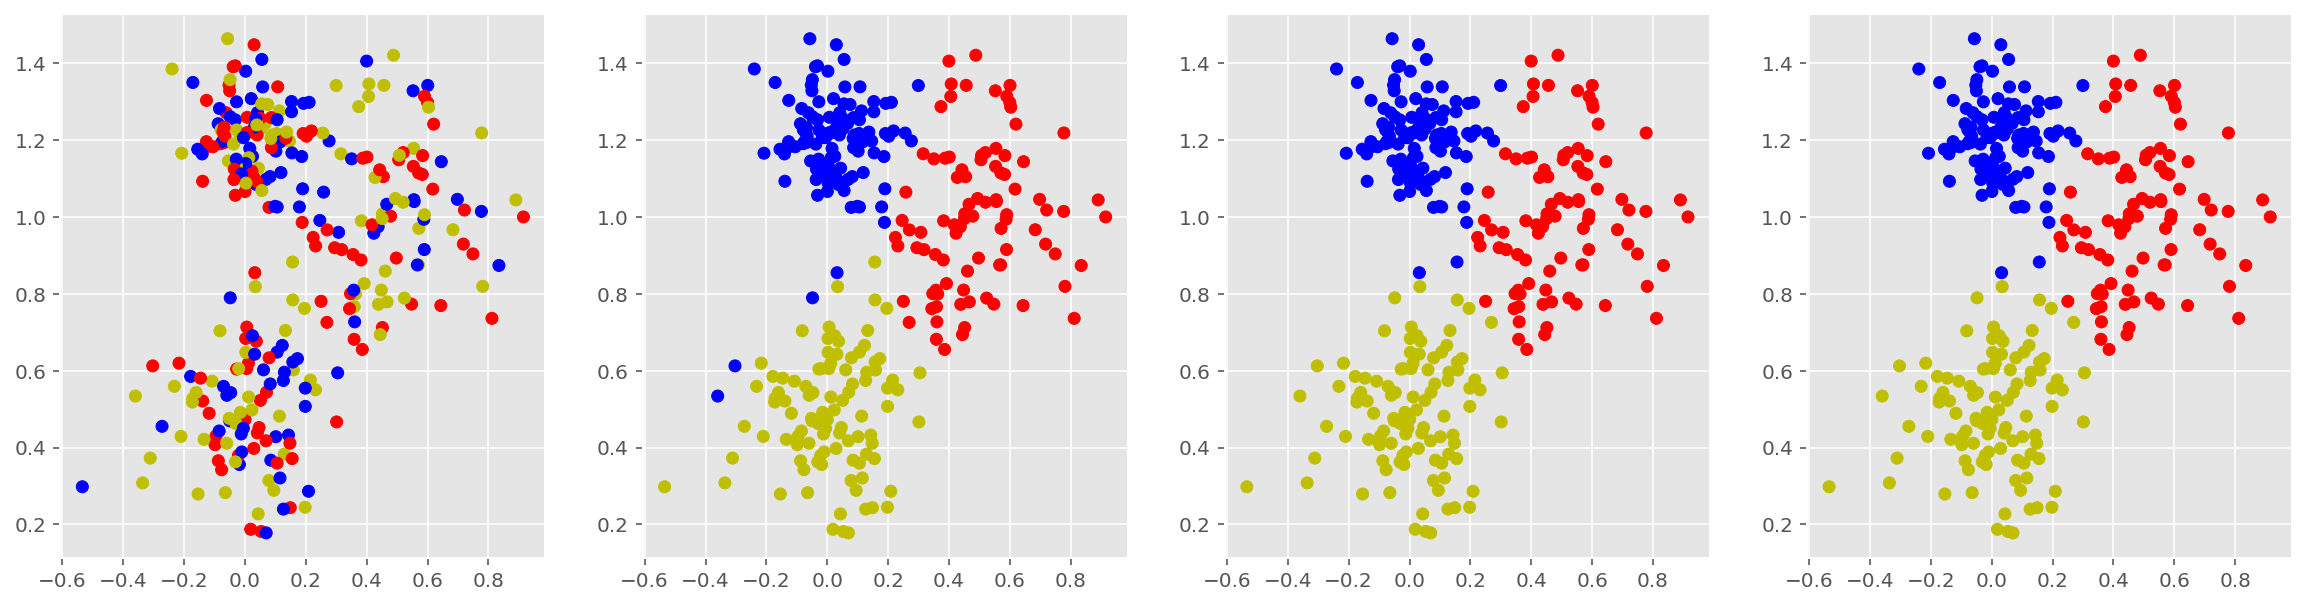

In [9]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['r', 'y','b'])
plt.figure(figsize=[20,5])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.scatter(data[:,0], data[:,1], c=C[i], cmap=cmap)

Look at the final four:


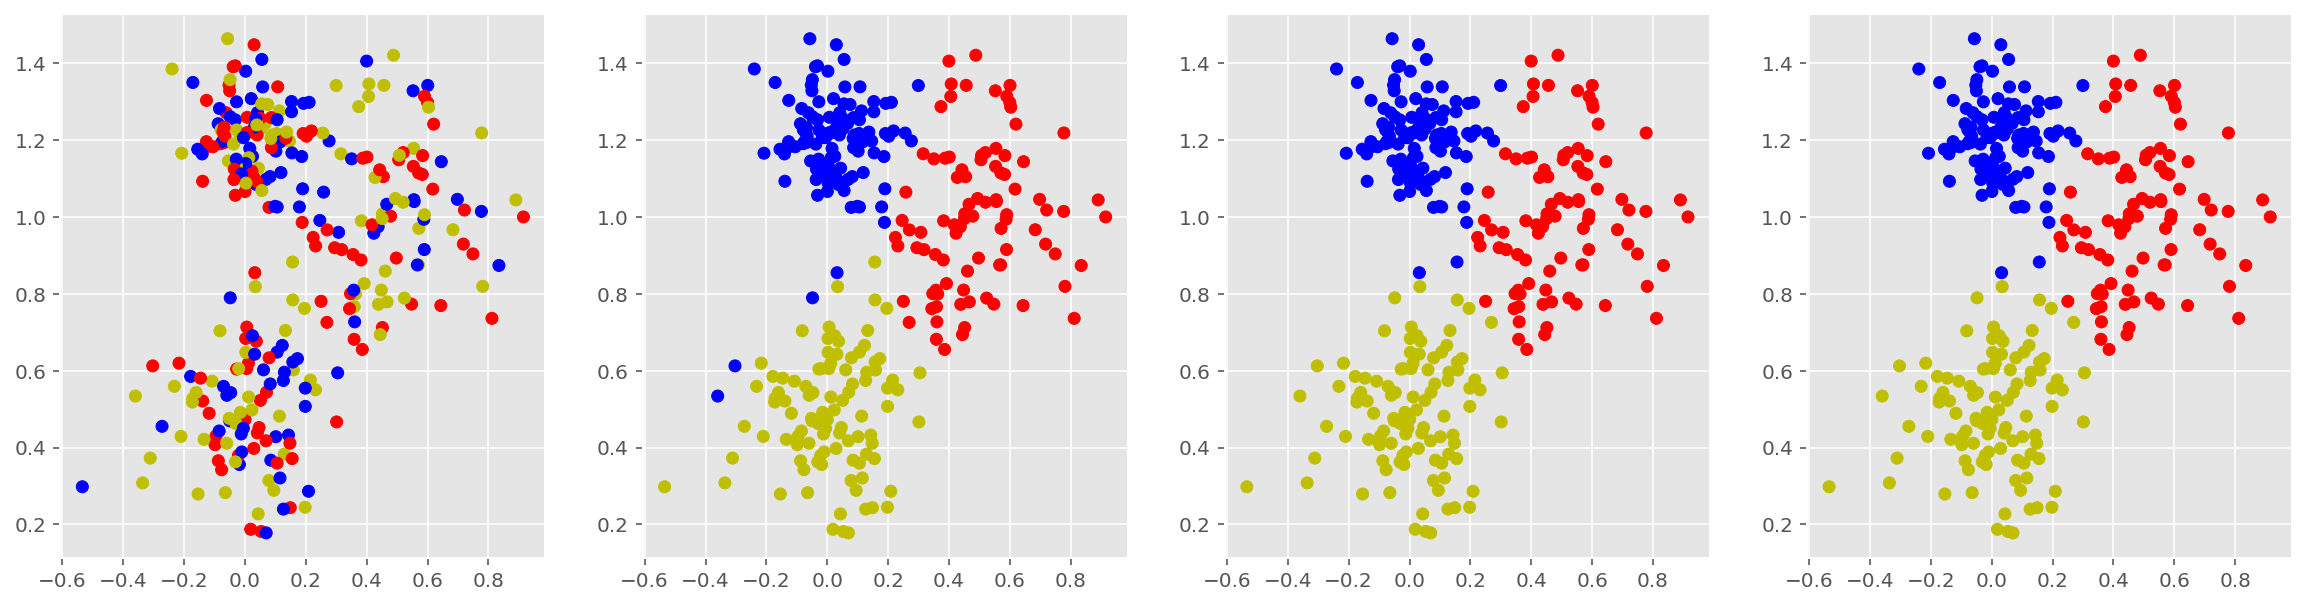

In [10]:
plt.figure(figsize=[20,5])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.scatter(data[:,0], data[:,1], c=C[-(4-i)], cmap=cmap)

Here's an implementation that picks K points at random and clusters on those points initially:

In [11]:
# a simple k-means implementation
# input: integer K, ndarray data
def KMeans2(K, data):
    n = data.shape[0]
    # intialize data using random centers
    centroids = data[np.random.randint(low=0, high=n, size=3)]
    dists = [[np.linalg.norm(d - centroids[k]) for k in range(K)] for d in data]
    c = np.argmin(np.array(dists), axis=1)
    C = [c]
    changed = True
    centroid = lambda k: np.mean(np.array([d for c,d in zip(c,data) if c == k]), axis=0)
    while changed:
        centroids = np.array([centroid(k) for k in range(K)])
        dists = [[np.linalg.norm(d - centroids[k]) for k in range(K)] for d in data]
        newc = np.argmin(np.array(dists), axis=1)
        changed = np.any(c != newc)
        C.append(newc)
        c = newc
    return C    

In [12]:
C = KMeans2(3, data)
print("Iterations:", len(C))

Iterations: 9


First few interations:


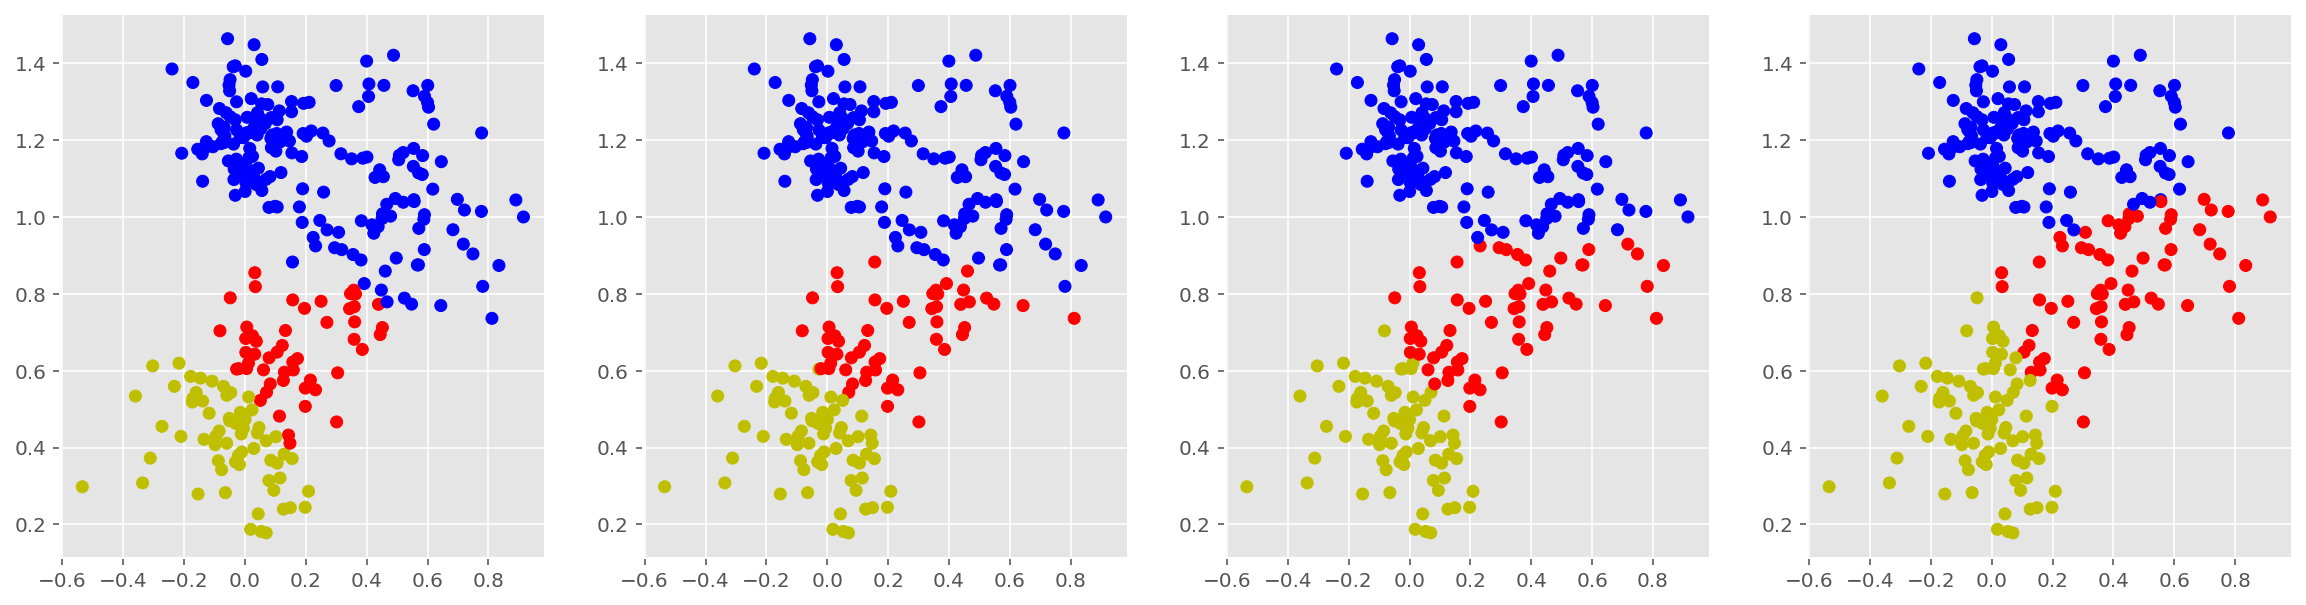

In [13]:
plt.figure(figsize=[20,5])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.scatter(data[:,0], data[:,1], c=C[i], cmap=cmap)

Final four:

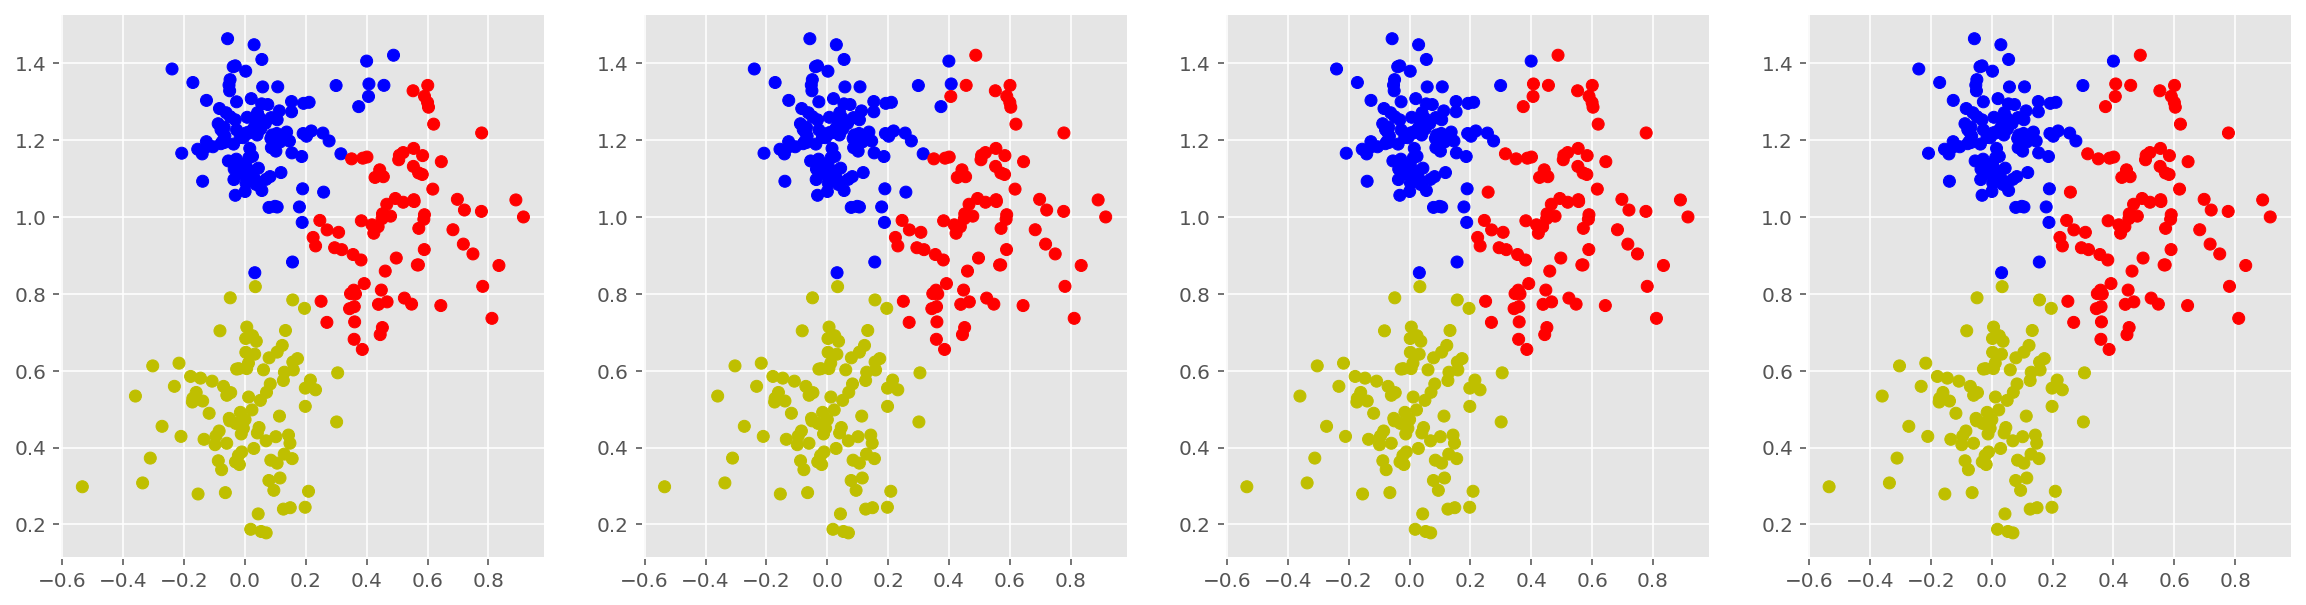

In [14]:
plt.figure(figsize=[20,5])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.scatter(data[:,0], data[:,1], c=C[-(4-i)], cmap=cmap)

Of course, scikit-learn gives us a robust KMeans object.

It behaves just like a classifier, except that you only give it inputs (no class labels).

The scikit-learn KMeans clusterer will actually try several random starts, and pick the "best" result.

Unfortunately, it doesn't give us a way to visualize the steps it went through.

In [15]:
from sklearn.cluster import KMeans
km = KMeans(3)
km.fit(data)

KMeans(n_clusters=3)

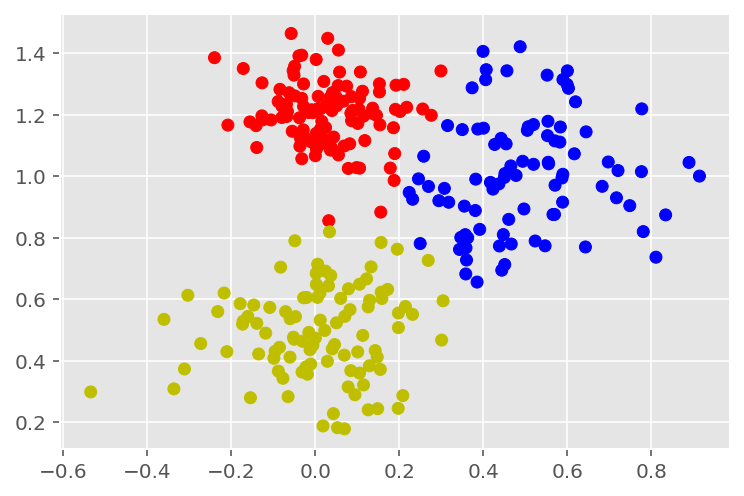

In [16]:
plt.scatter(data[:,0], data[:,1], c=km.predict(data), cmap=cmap)
plt.show()

## Guessing K
---
I know the data used above was generated from 3 Gaussian blobs, so we've been using K.

In general, though, how many clusters should there be?

How can we guess?

Let's try K=2:

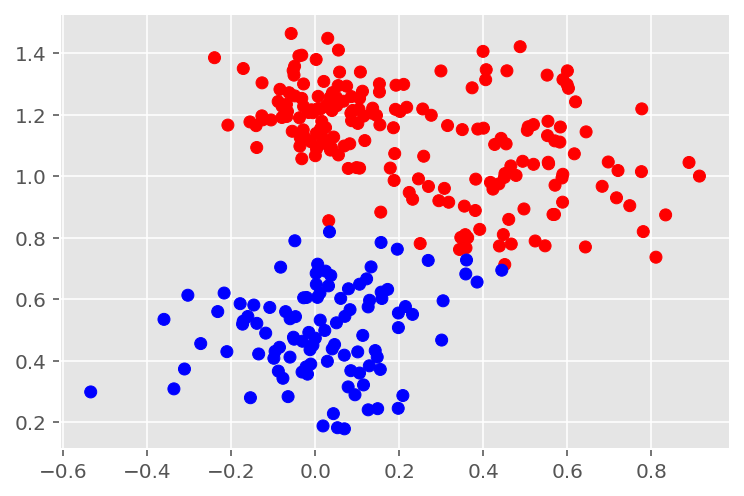

In [17]:
km2 = KMeans(2)
km2.fit(data)
plt.scatter(data[:,0], data[:,1], c=km2.predict(data), cmap=cmap)
plt.show()

Or K=4:

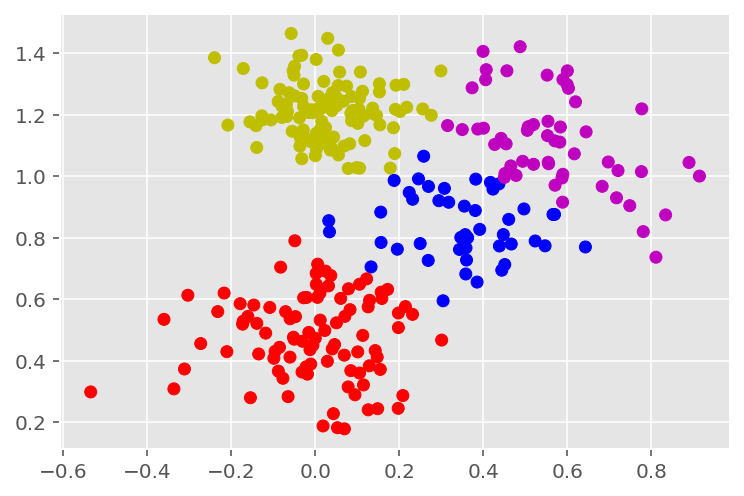

In [18]:
cmap = ListedColormap(['r','y','b','m'])
km4 = KMeans(4)
km4.fit(data)
plt.scatter(data[:,0], data[:,1], c=km4.predict(data), cmap=cmap)
plt.show()

Or K=10:

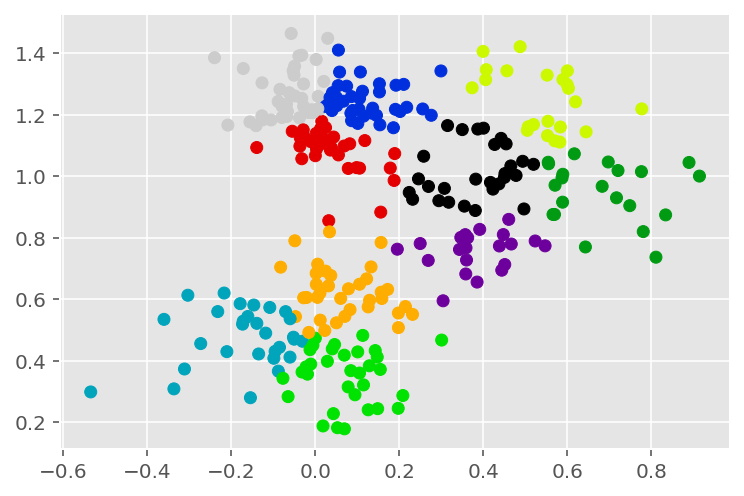

In [19]:
km10 = KMeans(10)
km10.fit(data)
plt.scatter(data[:,0], data[:,1], c=km10.predict(data), cmap='nipy_spectral')
plt.show()

## Hierarchical Clustering
---
One answer to the problem of "how many clusters":

Try all of them!

Hierarchical algorithms are either top down or bottom up.

The bottom up algorithms (agglomerative) are the most popular.

The result of hierarchical clustering is a *dendrogram* plot, showing how the clusters break down (or build up, if you prefer).

Dendrogram

A dendrogram is used to show the hierarchical relationship between objects and is the output of the hierarchical clustering. A dendrogram could potentially help with identifying the number of clusters to choose when applying hierarchical clustering.

To illustrate the concept of using a dendrogram, let’s create a dendrogram for the hierarchical clustering example above. As illustrated below, the distance between well numbers 1 and 2 is 0.2 as shown on the y-axis (distance) and the distance between well numbers 3 and 4 is 0.5. Finally, merged clusters 1,2 and 3,4 are connected and have a distance of 1.1.
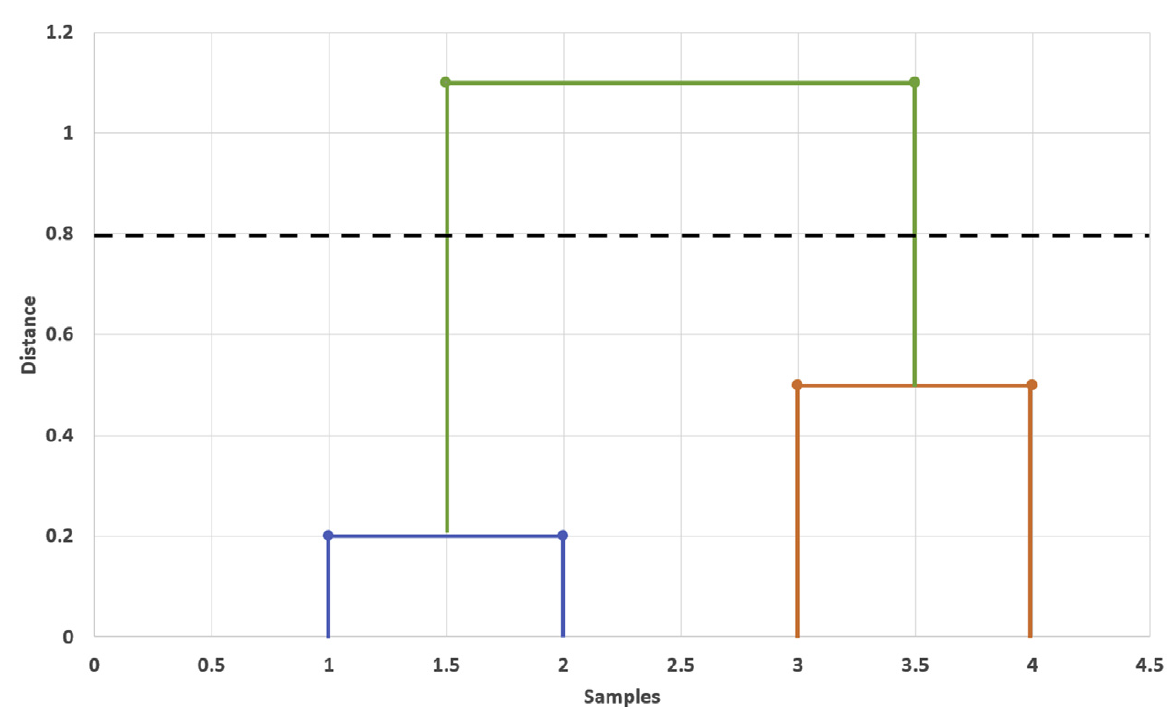

Let's first get a smaller dataset to illustrate.

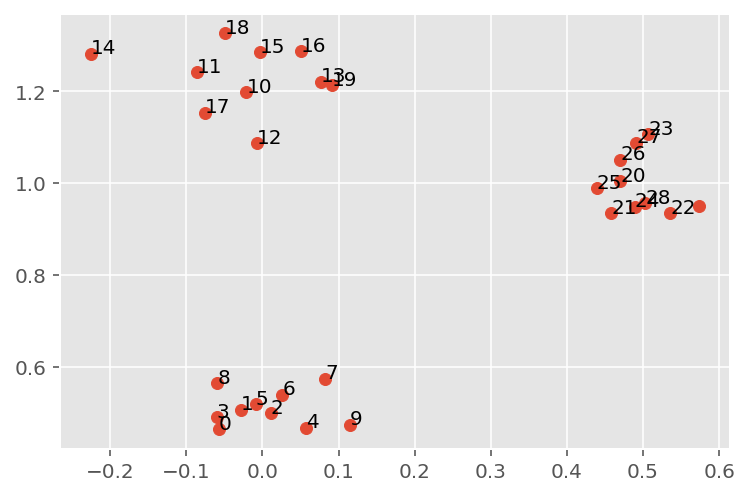

In [20]:
c1 = sample_cluster(10, 0, 0.5, 0.05)
c2 = sample_cluster(10, 0, 1.2, 0.1)
c3 = sample_cluster(10, 0.5, 1, 0.05)
data = np.concatenate((c1, c2, c3))
plt.scatter(data[:,0], data[:,1])
n = list(range(0,29))

for i, txt in enumerate(n):
     plt.annotate(txt, (data[:,0][i], data[:,1][i]))
plt.show()

While scikit-learn has agglomerative clustering, it isn't capable of showing us a dendrogram.

We'll use SciPy instead for this example.

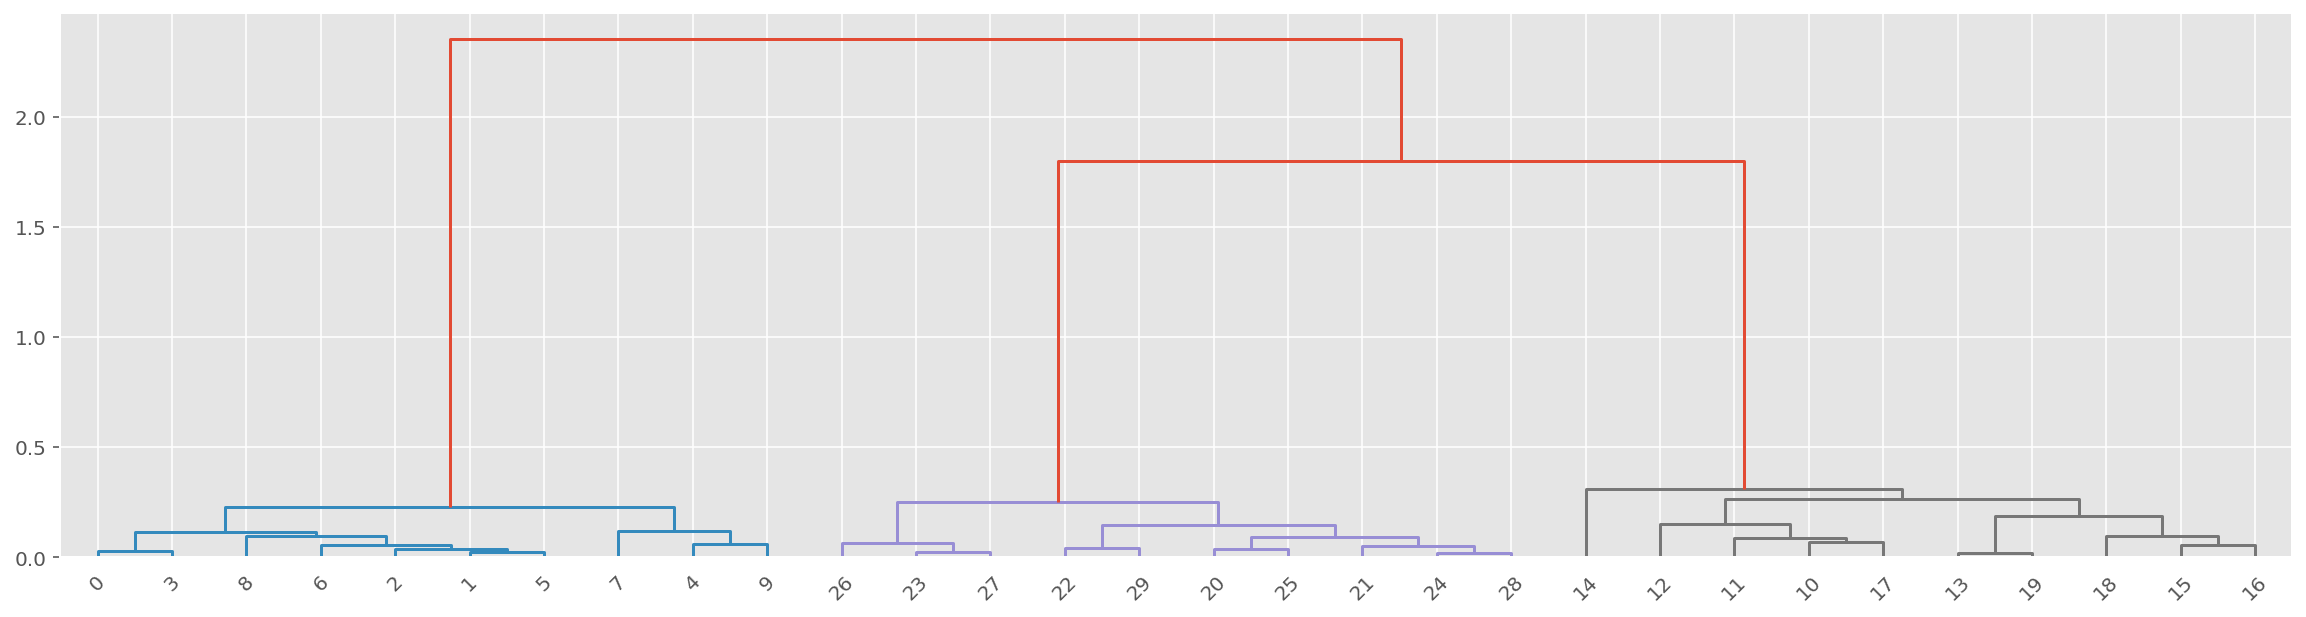

In [21]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(data)
plt.figure(figsize=[20,5])
dendrogram(linkage_array)
plt.show()

### Hierarchical Clustering Example

Dataset: 200 wells with their respective Gas in Place (GIP) and EUR/1000 ft.

In [22]:
df = pd.read_excel('Chapter4_ GIP_EUR_DataSet.xlsx')
df.describe()

,GIP (BCFperSection),EURper1000ft
count,200.00000,200.000000
mean,199.84800,2.201754
std,86.67358,1.132611
min,49.50000,0.043860
25%,136.95000,1.524123
50%,202.95000,2.192982
75%,257.40000,3.201754
max,452.10000,4.342105


In [23]:
df

,GIP (BCFperSection),EURper1000ft
0,49.5,1.710526
1,49.5,3.552632
2,52.8,0.263158
3,52.8,3.377193
4,56.1,1.754386
...,...,...
195,396.0,3.464912
196,415.8,1.228070
197,415.8,3.245614
198,452.1,0.789474


In [24]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_scaled=scaler.fit(df)
df_scaled=scaler.transform(df)
# df_scaled

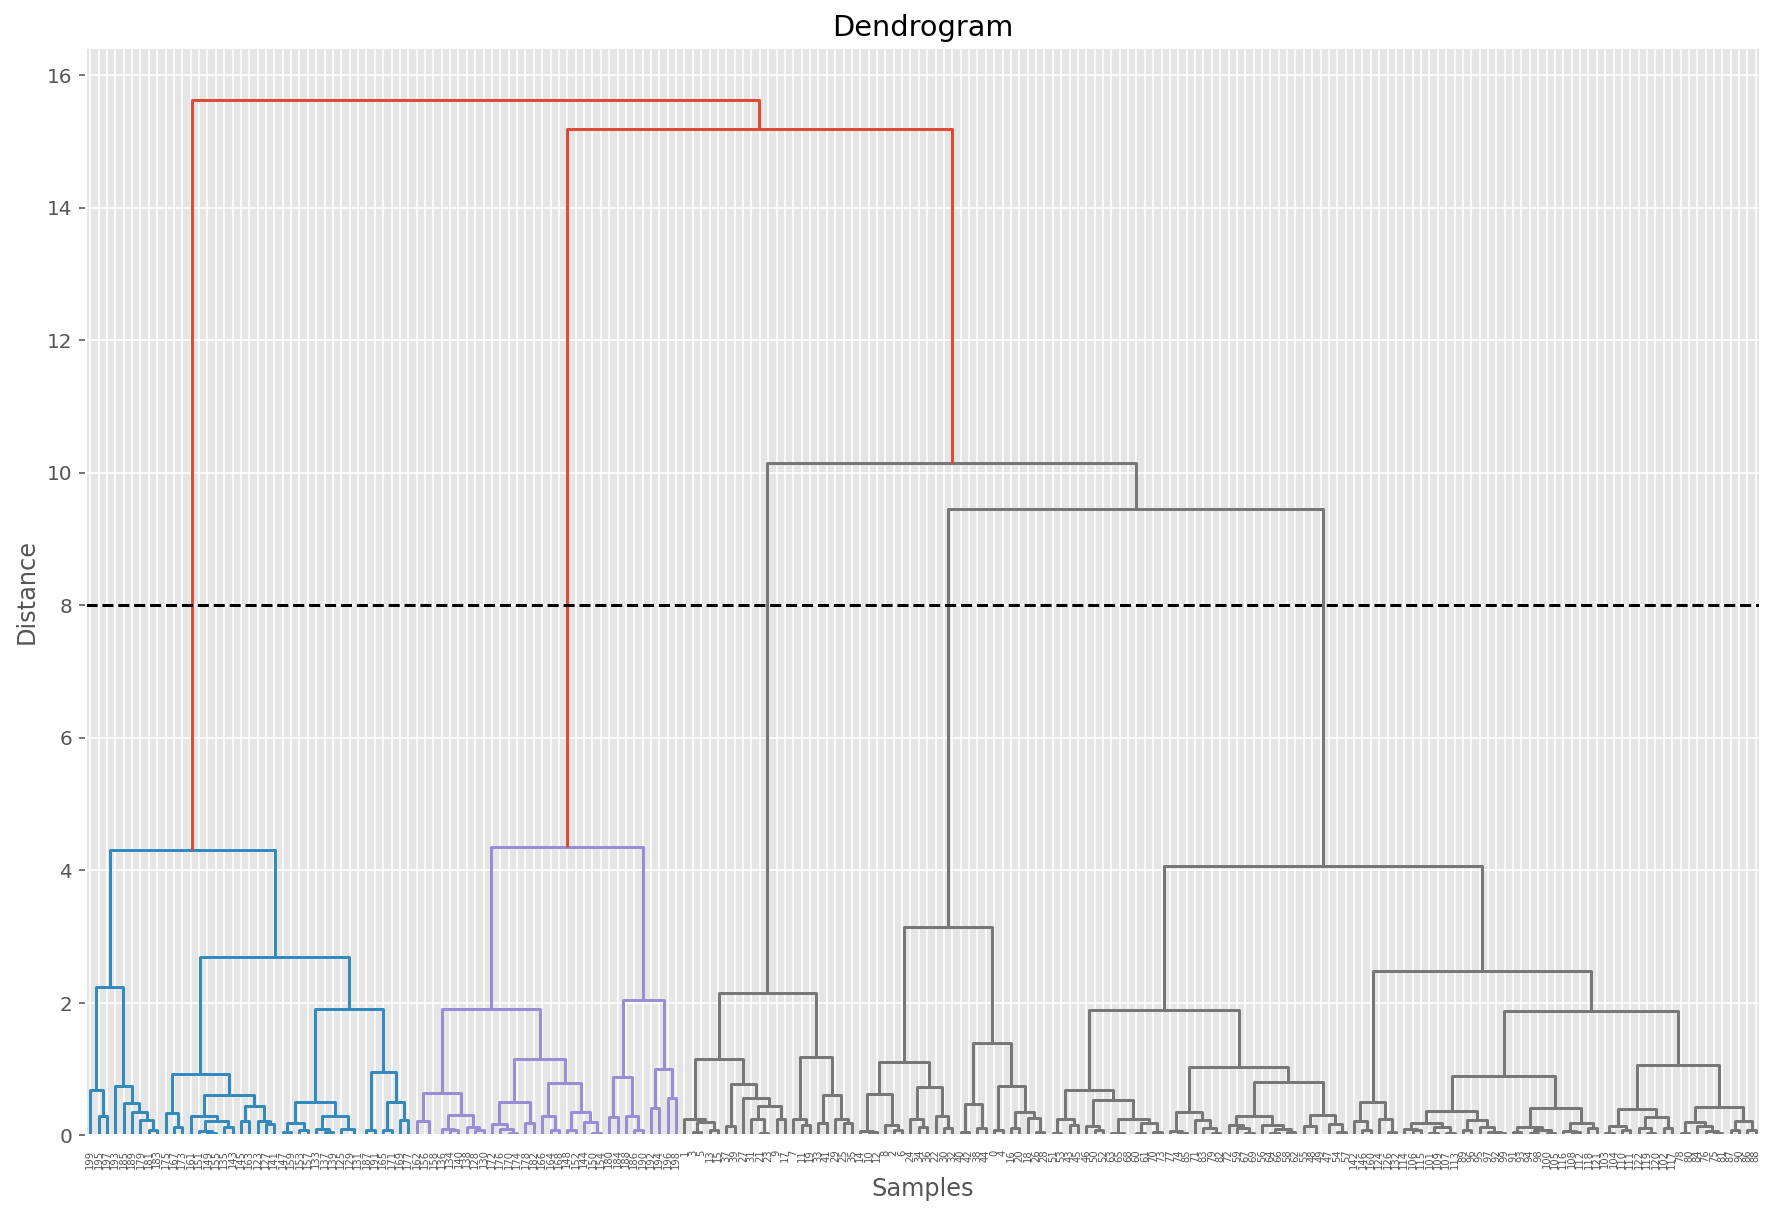

In [25]:
import scipy.cluster.hierarchy as shc   
plt.figure(figsize=(15, 10))
dend = shc.dendrogram(shc.linkage(df_scaled, method='ward'))
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title("Dendrogram") 
plt.axhline(y=8, color='k', linestyle='--')

Let’s now import agglomerative clustering and apply agglomerative clustering to "df_scaled" data frame. Under "AgglomerativeClustering," number of desired clusters can be accessed with attribute "n_clusters," "affinity" returns the metric used to compute the linkage. <br>

The linkage determines which distance to use between sets of observation. The "linkage" parameter can be set as (i) ward, (ii) average, (iii) complete or maximum, and (iv) single. <br>

"ward" minimizes the variance of the clusters being merged. "average" uses the average of the distances of each observation of the two sets. "complete" or "maximum" linkage uses the maximum distances between all observations of the two sets. "single" uses the minimum of the distances between all observations of the two sets. The default linkage of "ward" was used in this example.

In [26]:
from sklearn.cluster import AgglomerativeClustering
HC = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
HC=HC.fit_predict(df_scaled)
HC

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1,
       2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

In [27]:
df_scaled= pd.DataFrame(df_scaled,columns=df.columns[0:2])
df_scaled['Clusters']=HC
df_scaled

,GIP (BCFperSection),EURper1000ft,Clusters
0,-1.738999,-0.434801,4
1,-1.738999,1.195704,3
2,-1.700830,-1.715913,4
3,-1.700830,1.040418,3
4,-1.662660,-0.395980,4
...,...,...,...
195,2.268791,1.118061,1
196,2.497807,-0.861839,0
197,2.497807,0.923953,1
198,2.917671,-1.250054,0


Text(0.5, 0, 'silhouette coefficient')

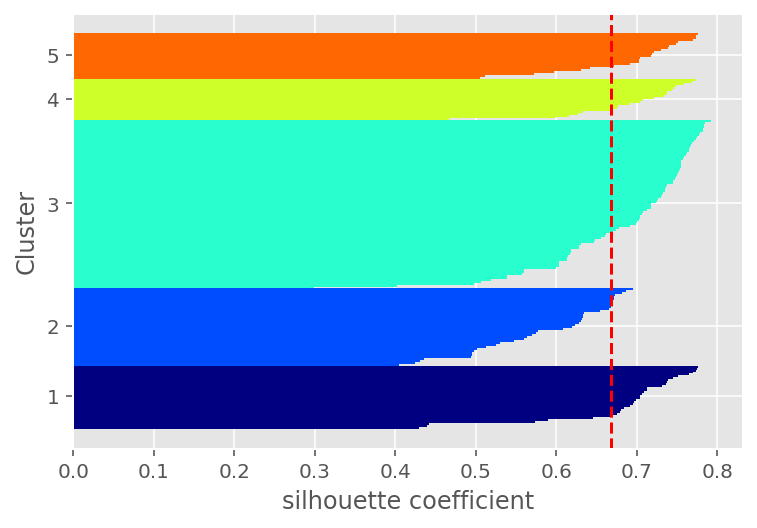

In [28]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels=np.unique(HC)
n_clusters=cluster_labels.shape[0]
silhouette_vals=silhouette_samples(df_scaled,HC,metric='euclidean')
y_ax_lower, y_ax_upper=0,0
yticks=[]
for i, c in enumerate (cluster_labels):
    c_silhouette_vals= silhouette_vals[HC==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color= cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals,height=1,edgecolor='none',color=color)
    yticks.append((y_ax_lower+y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg=np.mean(silhouette_vals)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.yticks(yticks, cluster_labels +1)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
# plt.show()

The averagesilhouette coefficient across all clusters is approximately 0.65.

The same process can be repeated with various numbers of clusters to find the average silhouette coefficient when different number of clusters are used.

The number of clusters with maximum average silhouette
value is desirable.

##### Silhouette coefficient
Another metric to evaluate the quality of clustering and it is often referred to as silhouette analysis. 

Silhouette analysis can be applied to other clustering algorithms as well. Silhouette coefficient ranges between -1 and 1, where a higher silhouette coefficient refers to a model with more coherent clusters. 

In other words, silhouette coefficients close to +1 means the sample is far away from the neighboring clusters. 

Avalue of 0 means that the sample is on or very close to the decision boundary between two neighboring clusters.

Finally, negative values indicate that the samples could have potentially been assigned to the wrong cluster

In [29]:
df_scaled['GIP (BCFperSection)']=(df_scaled['GIP (BCFperSection)']*(df['GIP (BCFperSection)'].std())+df['GIP (BCFperSection)'].mean())
df_scaled['EURper1000ft']=(df_scaled['EURper1000ft']*(df['EURper1000ft'].std())+df['EURper1000ft'].mean())


In [31]:
df_scaled

,GIP (BCFperSection),EURper1000ft,Clusters
0,49.122715,1.709294,4
1,49.122715,3.556021,3
2,52.430996,0.258293,4
3,52.430996,3.380143,3
4,55.739277,1.753263,4
...,...,...,...
195,396.492227,3.468082,1
196,416.341913,1.225627,0
197,416.341913,3.248234,1
198,452.733005,0.785930,0


In [32]:
Group_by=df_scaled.groupby(by='Clusters').mean()
Group_by

,GIP (BCFperSection),EURper1000ft
Clusters,,
0,295.279503,0.680128
1,285.792052,3.605628
2,184.139503,2.154681
3,82.520600,3.514146
4,86.520674,0.914015


In [34]:
df_scaled.groupby(by='Clusters').count()

,GIP (BCFperSection),EURper1000ft
Clusters,,
0,32,32
1,39,39
2,85,85
3,21,21
4,23,23


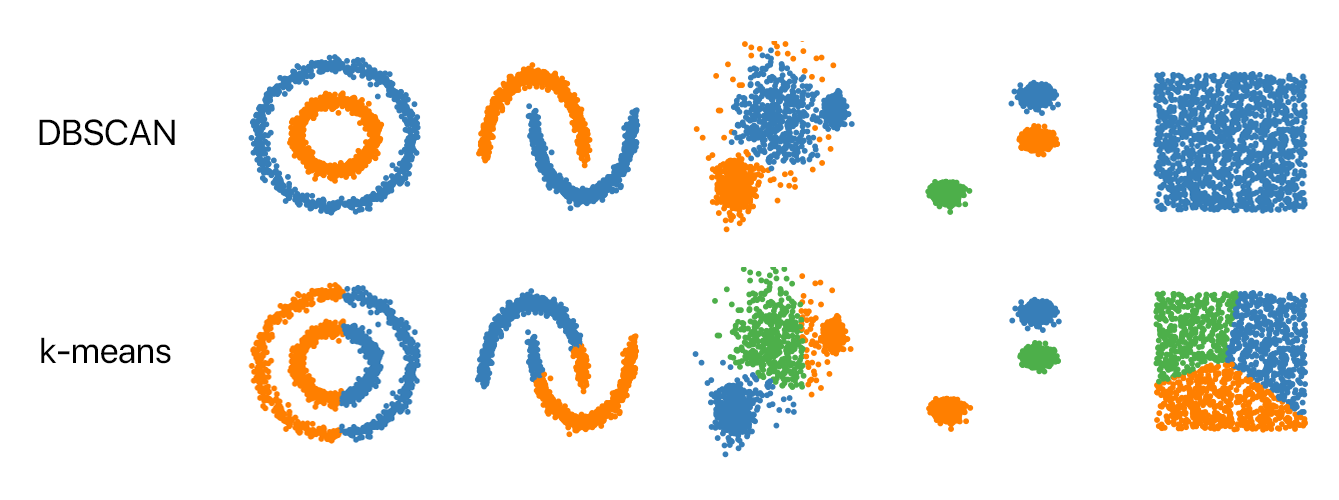
- DBSCAN creates unequally sized clusters. 




- KMeans creates evenly spaced centers.



- KMeans not suitable for nested data structures.



- DBScan is high performance model suitable for most practical cases.



- DBScan can find outliers.

## Data Preprocessing
---
- Generally useful to improve supervised learning algorithm performance
- Scaling/normalization:
  - Transform data so that features are on same scale or have same statistics
  - Helps some algorithms which are sensitive to scale
- Dimensionality reduction:
  - Transform data into a sub-space in which visualization or learning is easier
  - Reduce computational cost of learning

## Scaling
---
Is a thing.  It helps with some algorithms.

## Dimensionality Reduction
---
- Input data is often (very) high dimensional
- This can lead to expensive learning and promotes overfitting
- Variables can often also have high correlation
- Solution: extract most relevant sub-space of input data

## Principal Components Analysis
---
The most popular form of dimensionality reduction.

Lots of linear algebra behind this.  We won't go there.

Basically, rotates and transforms the data into a new subspace:
- Most relevance (variation) is now associated with first feature
- Second feature gets the next most, etc.

## PCA Example
---
Consider this dataset:

In [35]:
M = [[1, -1, 7],[20, 3, -5],[1,1,1]]
x1 = np.random.randn(300);
y1 = np.random.randn(300);
z1 = np.random.randn(300);
data1 = np.array([x1, y1, z1]).T @ M
x2 = np.random.randn(300);
y2 = np.random.randn(300);
z2 = np.random.randn(300);
data2 = np.array([x2, y2, z2]).T @ M + np.array([20,-10,15])
data = np.concatenate((data1, data2))

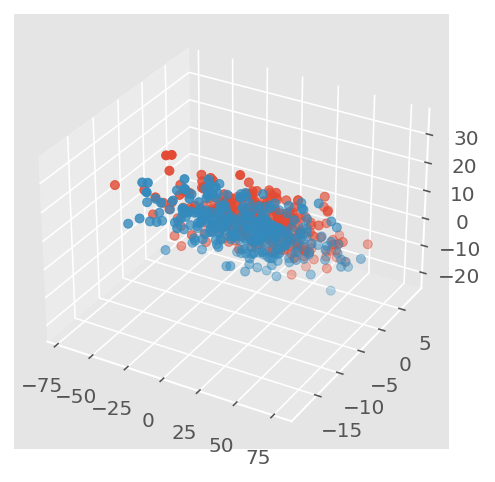

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data1[:,0], data1[:,1], data1[:,2])
ax.scatter(data2[:,0], data2[:,1], data2[:,2])
plt.show()

Let's apply PCA and look at the first two principal components.


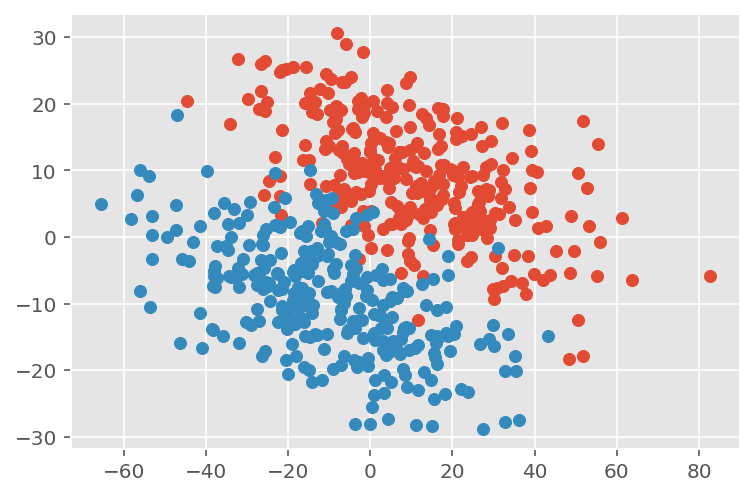

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)
data1_pca = pca.transform(data1)
data2_pca = pca.transform(data2)

plt.scatter(data1_pca[:,0], data1_pca[:,1])
plt.scatter(data2_pca[:,0], data2_pca[:,1])
plt.show()